## Load model's weight, and produce heatmaps

**Used Hyperparameter**<br>
Level: 2,3 images <br>
Number of train,val,test: 9, 3, 3 <br>
train's stride : 200 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


----------------------------------------------<br>
train_index = [2,4,5,6,7,15,17,19,20]<br>
valid_index = [0,12,18]<br>
test_index = [11,13,16]<br>

In [1]:
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialization
lowest_level = 2
highest_level = 3
train_val_stride = 200
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_23_split_933_stride_200_pmin_50'
saving_dir = os.path.join(dir,current_dir)
display(saving_dir)

'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50'

In [3]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [4]:
!apt-get install openslide-tools  # Openslide , Install the OpenSlide C library and Python bindings
!apt-get install python3-openslide # After installing these libraries, use `Runtime -> restart and run all` on the menu
from openslide import open_slide, __library_version__ as openslide_version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (143 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [5]:
# Gets difference of two lists using set operator
def difference(L1, L2):
    return (list(list(set(L1)-set(L2)) + list(set(L2)-set(L1))))

# detect and remove if number of images and masks are different
def balance_imgs(image_path_l, mask_path_l):
  img_num_l = [re.findall(r'\d+', string)[0] for string in image_path_l ] # list of image numbers
  mask_num_l = [re.findall(r'\d+', string)[0] for string in mask_path_l ] # list of mask's image numbers

  img_len = len(img_num_l)
  mask_len = len(mask_num_l)

  # delete images that are not same in number of lengths automatically
  if img_len != mask_len:
    print("Tissue image length: {}".format(len(image_path_l)))
    print("Mask image length: {}".format(len(mask_path_l)))

    diff_img_num = difference(img_num_l,mask_num_l)[0]

    if img_len > mask_len: # i.e. need to find extra image and delete
      print("Removed image number {} since there is no corresponding biopsy image".format(diff_img_num))
      del image_path_l[img_num_l.index(diff_img_num)]

    else: 
      print("Removed mask number {} since there is no corresponding  image".format(diff_img_num))
      del mask_path_l[mask_num_l.index(diff_img_num)]

  return image_path_l, mask_path_l


# Note: since importing slides from Professor's Google API does not work sometimes,
# we downloaded the images to 'locally' in Google Drive
directory = '/content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/'

biopsy_path_list = []
mask_path_list = []

for file in os.scandir(directory):
  
  if ("tif" in file.name):
    if ("mask" in file.name):
      mask_path_list.append(file.path) 
  
    else:
      biopsy_path_list.append(file.path)

# # Automatically removes images that are not both exists in image and masks
biopsy_path_list,mask_path_list = balance_imgs(biopsy_path_list,mask_path_list)

biopsy_path_list.sort()
mask_path_list.sort()

Tissue image length: 22
Mask image length: 21
Removed image number 038 since there is no corresponding biopsy image


In [6]:
def get_open_slide(tissue_path, mask_path, return_tissue):
# Function that opens an image based on path
# Note: return_tissue = boolean value, 
#      Ture -> reads tissue img, False -> reads masks image

  slide = open_slide(tissue_path)
  print ("Read WSI from %s with width: %d, height: %d" % (tissue_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))
  mask = open_slide(mask_path)
  print ("Read tumor mask from %s" % (mask_path))

  print("Slide includes %d levels", min(len(slide.level_dimensions),len(mask.level_dimensions)))
  for i in range(min(len(slide.level_dimensions),len(mask.level_dimensions))):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                              slide.level_dimensions[i], 
                                                              slide.level_downsamples[i]))

      assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  if (return_tissue):
    return slide
  else:
    return mask

## Loads model weights

In [7]:
filesname_mdl_9_3_wo_ft_wo_da = 'mdl_9_3_wo_ft_wo_da.h5/'
filesname_mdl_9_3_wo_ft_w_da = 'mdl_9_3_wo_ft_w_da.h5/'
filesname_mdl_9_3_w_ft_wo_da = 'mdl_9_3_w_ft_wo_da.h5/'
filesname_mdl_9_3_w_ft_w_da = 'mdl_9_3_w_ft_w_da.h5/'
filename_mdl_9_3_wo_ft_wo_da_BN = 'mdl_9_3_wo_ft_wo_da_BN.h5/'
filename_mdl_9_3_wo_ft_wo_da_Dropout = "mdl_9_3_wo_ft_wo_da_Dropout.h5/"
filename_mdl_9_3_wo_ft_wo_da_BN_DO = 'mdl_9_3_wo_ft_wo_da_BN_DO.h5/'

path_mdl_9_3_wo_ft_wo_da = os.path.join(saving_dir, filesname_mdl_9_3_wo_ft_wo_da)
path_mdl_9_3_wo_ft_w_da = os.path.join(saving_dir, filesname_mdl_9_3_wo_ft_w_da)
path_mdl_9_3_w_ft_wo_da = os.path.join(saving_dir, filesname_mdl_9_3_w_ft_wo_da)
path_mdl_9_3_w_ft_w_da = os.path.join(saving_dir,filesname_mdl_9_3_w_ft_w_da)
path_mdl_9_3_wo_ft_wo_da_BN = os.path.join(saving_dir,filename_mdl_9_3_wo_ft_wo_da_BN)
path_mdl_9_3_wo_ft_wo_da_Dropout = os.path.join(saving_dir,filename_mdl_9_3_wo_ft_wo_da_Dropout)
path_mdl_9_3_wo_ft_wo_da_BN_DO = os.path.join(saving_dir,filename_mdl_9_3_wo_ft_wo_da_BN_DO)

print(path_mdl_9_3_wo_ft_wo_da) # Version a - model w/o fine tuning, w/o data augmentation
print(path_mdl_9_3_wo_ft_w_da) # Version b  - model w/o fine tuning, w data augmentation
print(path_mdl_9_3_w_ft_wo_da) # Version c  - model w fine tuning, w/o data augmentation
print(path_mdl_9_3_w_ft_w_da) # Version d   - model w/o fine tuning, w/o data augmentation
print(path_mdl_9_3_wo_ft_wo_da_BN) # Version 2.a - model w/o fine tuning, w/o data augmentation, added dense, Batch Normalization
print(path_mdl_9_3_wo_ft_wo_da_Dropout) # Version 2.b - model w/o fine tuning, w/o data augmentation, added dense, Dropout
print(path_mdl_9_3_wo_ft_wo_da_BN_DO) # Version 2.c - model w/o fine tuning, w/o data augmentation, added dense, Batch Norm + Dropout

/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_wo_ft_wo_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_wo_ft_w_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_w_ft_wo_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_w_ft_w_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_wo_ft_wo_da_BN.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_wo_ft_wo_da_Dropout.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50/mdl_9_3_wo_ft_wo_da_BN_DO.h5/


In [8]:
# test_index = [11,13,16]
current_test_index = 16

In [9]:
zoom1_test = np.load(os.path.join(saving_dir,'zoom1_test_' + str(current_test_index) + '.npy'))
zoom2_test = np.load(os.path.join(saving_dir,'zoom2_test_' + str(current_test_index) + '.npy'))
label_test = np.load(os.path.join(saving_dir,'label_test_' + str(current_test_index) + '.npy'))
patches_num_test = np.load(os.path.join(saving_dir,'patches_num_test_' + str(current_test_index) + '.npy'))

In [10]:
test_index = [current_test_index]
biopsy_test = [biopsy_path_list[i] for i in test_index]
mask_test = [mask_path_list[i] for i in test_index]

In [11]:
biopsy_slides_test = [get_open_slide(x,y,True) for x,y in zip(biopsy_test, mask_test)]
mask_slides_test = [get_open_slide(x,y,False) for x,y in zip(biopsy_test, mask_test)]

Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128
Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downs

In [12]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [13]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

In [14]:
def add_layers(model, add_BN, add_Dropout):
  if add_BN:
    if add_Dropout:
      print("Added BN and Dropout")
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1, activation='sigmoid')(model)
      return model
    
    else: # i.e. only add Batch Normalization
      print("Added only BN")
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1, activation='sigmoid')(model)
      return model

    
  else: # i.e. only apply Dropout
    print("Added only Dropout")
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(128, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1, activation='sigmoid')(model)
    return model

In [15]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune, add_BN, add_Dropout):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  model = add_layers(model = model, add_BN = add_BN, add_Dropout = add_Dropout)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

In [16]:
def run_model(mdl, mdl_path, X_test):
  
  mdl.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
  mdl.load_weights(mdl_path)
  history = mdl.evaluate(X_test, label_test, batch_size = BATCH_SIZE)

  y_pred = mdl.predict(X_test)
  y_pred_binary = np.where(y_pred > 0.5, 1, 0)

  return history, y_pred_binary


In [17]:
def run_prediction (history, y_pred_binary, patches_num_test):
  # Best Model Base case # 11

  previous = 0
  for i in range(1):
    biopsy_slide_temp = biopsy_slides_test[i]
    mask_slide_temp = mask_slides_test[i]
    level = 3

    print(biopsy_slide_temp.level_dimensions[3][0], biopsy_slide_temp.level_dimensions[3][1])

    biopsy_slide_temp = read_slide(biopsy_slide_temp,x=0,y=0,level=level,width=biopsy_slide_temp.level_dimensions[3][0],height = biopsy_slide_temp.level_dimensions[3][1])
    mask_slide_temp = read_slide(mask_slide_temp,x=0,y=0,level=level,width=mask_slide_temp.level_dimensions[3][0],height = mask_slide_temp.level_dimensions[3][1])
    

    length = patches_num_test[i][0]
    x_count =patches_num_test[i][1]
    y_count = patches_num_test[i][2]

    # print(len(y_pred_binary[:length]))

    #length, x_count, y_count = 7176, 78, 92

    patches_predict = y_pred_binary[previous:previous+length]

    previous = length

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    axes[0].imshow(biopsy_slide_temp)
    axes[1].imshow(mask_slide_temp[:,:,0])
    axes[2].imshow(np.reshape(patches_predict,(y_count,x_count)))
    axes[0].set_title(history)

    prediction = np.reshape(patches_predict,(y_count,x_count)).astype('float32')
    reshape = cv2.resize(prediction,(biopsy_slides_test[i].level_dimensions[3][0],biopsy_slides_test[i].level_dimensions[3][1]))
    reshape = (reshape > 0.95).astype(int)
    axes[3].imshow(reshape)

In [18]:
import cv2
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0. 
# There is an example below of working with coordinates with respect to a higher zoom level.

# Read a region from the slide, Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [19]:
#Reference: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

dict_characters = {0: 'non-tumor', 1: 'tumor'}

def print_stats(label_test, y_pred_binary):
  confusion_mat = confusion_matrix(label_test, y_pred_binary)
  plot_confusion_matrix(confusion_mat, classes = list(dict_characters.values()))

  tn, fp, fn, tp = confusion_mat.ravel()
  print()
  print("False Positive rate: " + str(round(fp/(fp+tn),2)))
  print("False Negative rate: " + str(round(fn/(fn+tp),2)))
  print("True Positive rate: " + str(round(tp/(tp+fn),2)))
  print("True Negative rate: " + str(round(tn/(fp+tn),2)))
  print()
  print(classification_report(label_test, y_pred_binary))
  fpr, tpr, thresholds = roc_curve(label_test, y_pred_binary,pos_label=1)
  print()
  print("AUC score: " + str(round(auc(fpr,tpr),2)))

In [20]:
BATCH_SIZE = 32
X_test = [zoom1_test, zoom2_test]

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

69/69 [==============================] - 20s 157ms/step - loss: 0.1019 - accuracy: 0.9616
7680 6720

False Positive rate: 0.04
False Negative rate: 0.31
True Positive rate: 0.69
True Negative rate: 0.96

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2129
           1       0.37      0.69      0.49        71

    accuracy                           0.95      2200
   macro avg       0.68      0.83      0.73      2200
weighted avg       0.97      0.95      0.96      2200


AUC score: 0.83


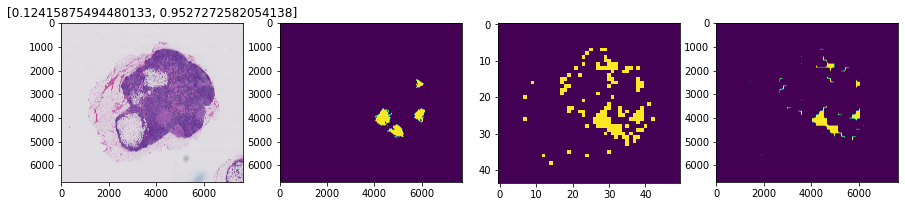

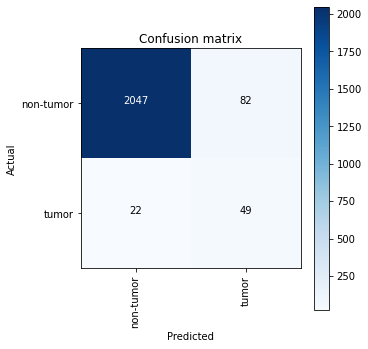

In [21]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_two(fine_tune = False)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_wo_da,path_mdl_9_3_wo_ft_wo_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_wo_ft_wo_da, history, y_pred_binary

### Version b <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
69/69 [==============================] - 15s 143ms/step - loss: 0.1382 - accuracy: 0.9820
7680 6720

False Positive rate: 0.0
False Negative rate: 1.0
True Positive rate: 0.0
True Negative rate: 1.0

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2129
           1       0.00      0.00      0.00        71

    accuracy                           0.97      2200
   macro avg       0.48      0.50      0.49      2200
weighted avg       0.94      0.97      0.95      2200


AUC score: 0.5


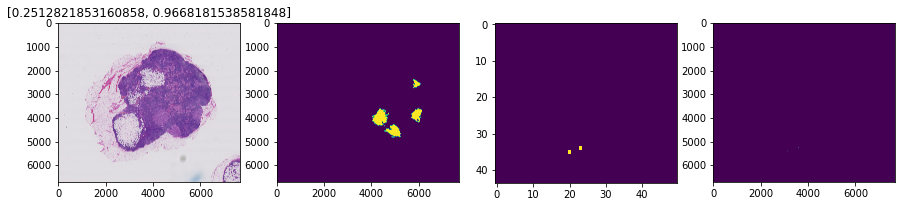

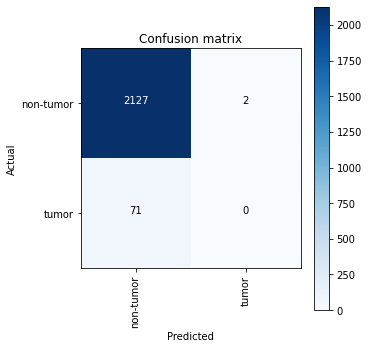

In [22]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_two(fine_tune = True)
history, y_pred_binary = run_model(mdl_9_3_w_ft_wo_da,path_mdl_9_3_w_ft_wo_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_w_ft_wo_da, history, y_pred_binary

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

69/69 [==============================] - 14s 143ms/step - loss: 0.1264 - accuracy: 0.9527
7680 6720

False Positive rate: 0.04
False Negative rate: 0.46
True Positive rate: 0.54
True Negative rate: 0.96

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2129
           1       0.31      0.54      0.40        71

    accuracy                           0.95      2200
   macro avg       0.65      0.75      0.68      2200
weighted avg       0.96      0.95      0.95      2200


AUC score: 0.75


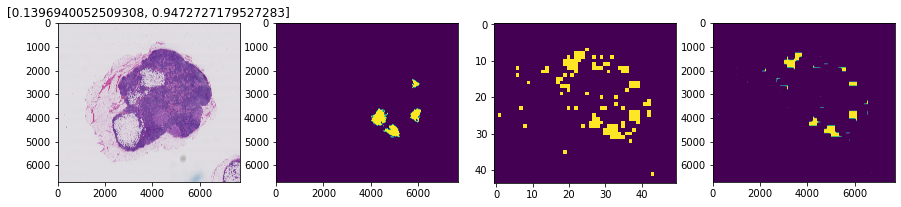

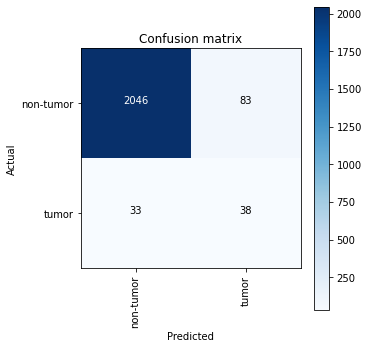

In [23]:
mdl_9_3_wo_ft_w_da = create_model_keras_inputs_two(fine_tune = False)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_w_da,path_mdl_9_3_wo_ft_w_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_wo_ft_w_da, history, y_pred_binary

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
69/69 [==============================] - 15s 143ms/step - loss: 0.1522 - accuracy: 0.9732
7680 6720

False Positive rate: 0.02
False Negative rate: 0.69
True Positive rate: 0.31
True Negative rate: 0.98

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2129
           1       0.38      0.31      0.34        71

    accuracy                           0.96      2200
   macro avg       0.68      0.65      0.66      2200
weighted avg       0.96      0.96      0.96      2200


AUC score: 0.65


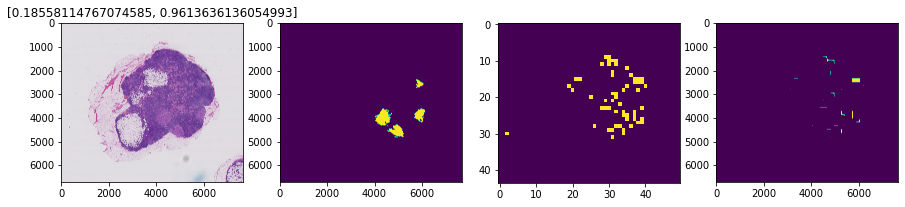

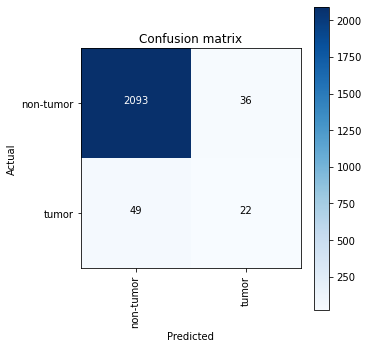

In [24]:
mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
history, y_pred_binary = run_model(mdl_9_3_w_ft_w_da,path_mdl_9_3_w_ft_w_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_w_ft_w_da, history, y_pred_binary

### Version 2.a: Batch Normalization <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normalization and extra dense layer

Added only BN
69/69 [==============================] - 15s 143ms/step - loss: 0.2134 - accuracy: 0.9203
7680 6720

False Positive rate: 0.09
False Negative rate: 0.2
True Positive rate: 0.8
True Negative rate: 0.91

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2129
           1       0.23      0.80      0.36        71

    accuracy                           0.91      2200
   macro avg       0.61      0.86      0.66      2200
weighted avg       0.97      0.91      0.93      2200


AUC score: 0.86


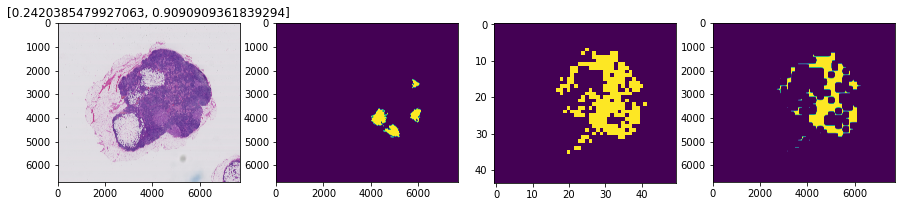

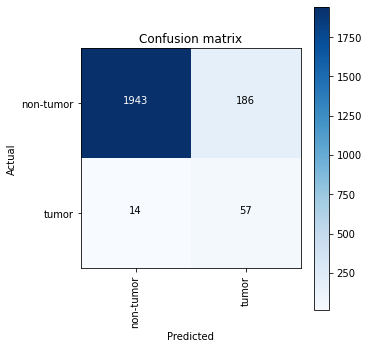

In [29]:
mdl_9_3_wo_ft_wo_da_BN = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = False)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_wo_da_BN,path_mdl_9_3_wo_ft_wo_da_BN, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_wo_ft_wo_da_BN, history, y_pred_binary

### Version 2.b: Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Dropout and extra dense layer

Added only Dropout
69/69 [==============================] - 14s 143ms/step - loss: 0.0904 - accuracy: 0.9681
7680 6720

False Positive rate: 0.03
False Negative rate: 0.31
True Positive rate: 0.69
True Negative rate: 0.97

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2129
           1       0.45      0.69      0.54        71

    accuracy                           0.96      2200
   macro avg       0.72      0.83      0.76      2200
weighted avg       0.97      0.96      0.97      2200


AUC score: 0.83


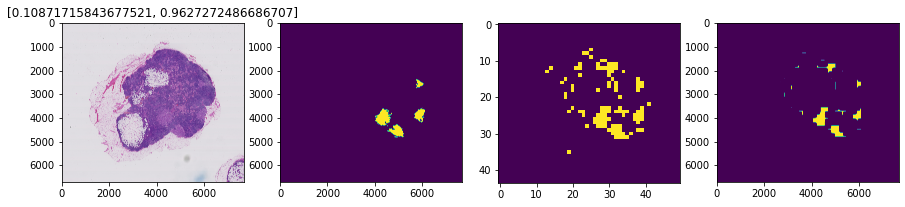

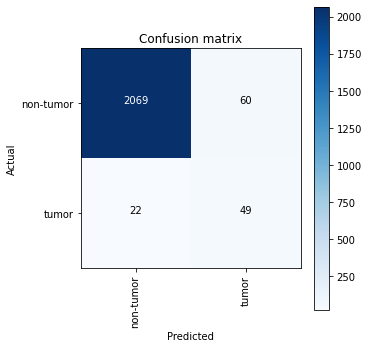

In [26]:
mdl_9_3_wo_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = False, add_Dropout = True)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_wo_da_Dropout,path_mdl_9_3_wo_ft_wo_da_Dropout, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_wo_ft_wo_da_Dropout, history, y_pred_binary

### Version 2.c: Batch Norm + Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normailzation, Dropout, and extra dense layer

Added BN and Dropout
69/69 [==============================] - 15s 143ms/step - loss: 0.1596 - accuracy: 0.9355
7680 6720

False Positive rate: 0.07
False Negative rate: 0.23
True Positive rate: 0.77
True Negative rate: 0.93

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2129
           1       0.27      0.77      0.40        71

    accuracy                           0.92      2200
   macro avg       0.63      0.85      0.68      2200
weighted avg       0.97      0.92      0.94      2200


AUC score: 0.85


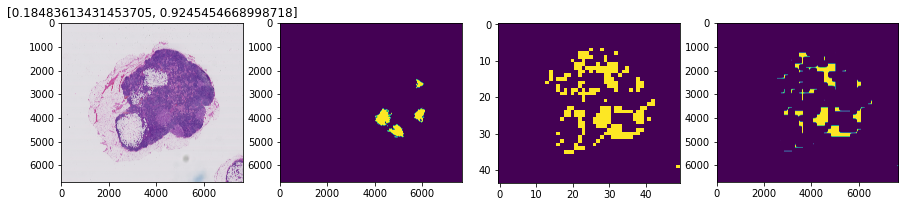

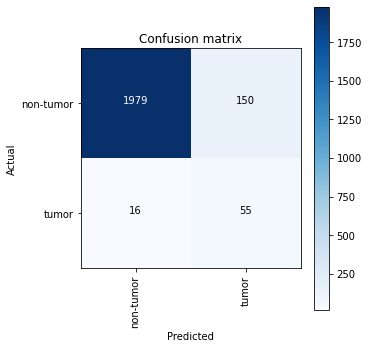

In [28]:
mdl_9_3_wo_ft_wo_da_BN_DO = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = True)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_wo_da_BN_DO,path_mdl_9_3_wo_ft_wo_da_BN_DO, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

print_stats(label_test, y_pred_binary)
del mdl_9_3_wo_ft_wo_da_BN_DO, history, y_pred_binary